# 10章 : 拡散モデルの応用

## 条件付け拡散モデル
拡散モデルは以下
$$
\begin{align}
p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t\right) &= \mathcal{N}\left(\boldsymbol{x}_{t-1}; \boldsymbol{\mu}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t\right), \sigma_q^2\left(t\right)\boldsymbol{I}\right)\\
p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0\right) &= \int p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0, \boldsymbol{x}_1, \cdots, \boldsymbol{x}_T\right)d\boldsymbol{x}_1 d\boldsymbol{x}_2\cdots d \boldsymbol{x}_T \quad \left(\text{確率の周辺化}\right)\\
&= \int p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1\right)\cdots p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{T-1} \mid \boldsymbol{x}_T\right) p \left(\boldsymbol{x}_T\right)d\boldsymbol{x}_1 d\boldsymbol{x}_2\cdots d \boldsymbol{x}_T \quad \left(\text{マルコフ性}\right)
\end{align}
$$

条件$y$を加えた条件付き拡散モデルは以下
$$
\begin{align}
p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid y\right)
&= \int p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_0 \mid \boldsymbol{x}_1, y\right)\cdots p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{T-1} \mid \boldsymbol{x}_T, y\right) p \left(\boldsymbol{x}_T\right)d\boldsymbol{x}_1 d\boldsymbol{x}_2\cdots d \boldsymbol{x}_T\\
p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_{t-1} \mid \boldsymbol{x}_t, y\right) &= \mathcal{N}\left(\boldsymbol{x}_{t-1}; \boldsymbol{\mu}_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, y\right), \sigma_q^2\left(t\right)\boldsymbol{I}\right)
\end{align}
$$

## 条件付け拡散モデルの実装

In [1]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )
    
    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v) # ブロードキャスト
        return y

In [3]:
def _pos_encoding(t, output_dim, device="cpu"):
    D = output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device) # [0, 1, ... , D-1]
    div_term = 10000 ** (i / D)

    v[0::2] = torch.sin(t / div_term[0::2]) # 偶数index
    v[1::2] = torch.cos(t / div_term[1::2]) # 奇数index
    
    return v

def pos_encoding(ts, output_dim, device="cpu"):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

条件$y$をEmbeddingでベクトル化して時刻$t$を位置エンコーディンしたものと足し合わせる
`nn.Linear()`と`nn.Embedding()`の違いは以下参照
- https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
- linearはただの線形変換で行列$A$とバイアス$b$を学習
- Embeddingはテンソルの階数が1個増える

In [4]:
# 条件付けUNetの実装(入力:x, t, yにも対応できるように拡張)
class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)
    
    def forward(self, x, timesteps, labels=None):
        # 正弦波位置エンコーディング
        t = pos_encoding(timesteps, self.time_embed_dim, x.device)

        # ラベルの処理(条件付け)
        if labels is not None:
            t += self.label_emb(labels)
        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)
        
        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x

データ生成実装

In [5]:
from tqdm import tqdm # プログレスバーを表示するため
import torchvision.transforms as transforms

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= self.num_timesteps).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

        return x_t, noise
    
    # デノイズ処理
    def denoise(self, model, x, t, labels): # labels追加
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        # ブロードキャストのため
        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0 # t=1のノイズは0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) /(1 - alpha_bar))
        return mu + noise * std
    
    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        # labelランダムに生成
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)
        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels)
        
        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels

学習コード実装

100%|██████████| 1000/1000 [00:05<00:00, 199.90it/s]


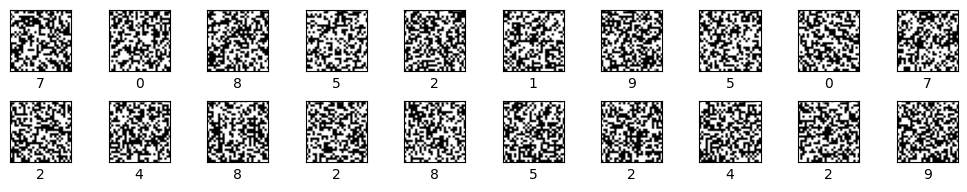

100%|██████████| 469/469 [00:24<00:00, 18.81it/s]


Epoch 0 | Loss: 0.046685188464613864


100%|██████████| 1000/1000 [00:04<00:00, 200.32it/s]


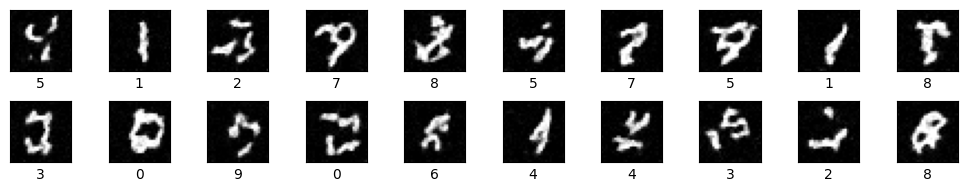

100%|██████████| 469/469 [00:24<00:00, 18.78it/s]


Epoch 1 | Loss: 0.026380554608095175


100%|██████████| 1000/1000 [00:04<00:00, 200.70it/s]


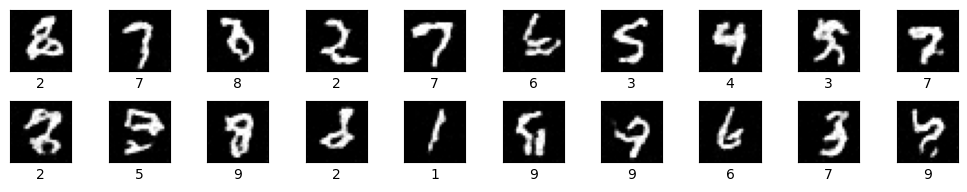

100%|██████████| 469/469 [00:24<00:00, 18.76it/s]


Epoch 2 | Loss: 0.02278737854291953


100%|██████████| 1000/1000 [00:05<00:00, 199.96it/s]


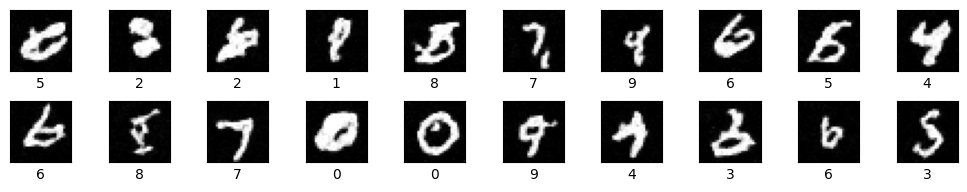

100%|██████████| 469/469 [00:24<00:00, 18.76it/s]


Epoch 3 | Loss: 0.020784628807878826


100%|██████████| 1000/1000 [00:05<00:00, 199.17it/s]


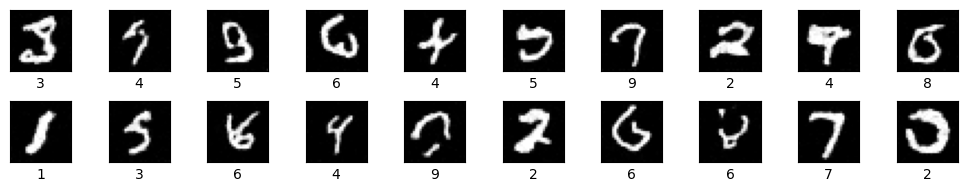

100%|██████████| 469/469 [00:24<00:00, 18.83it/s]


Epoch 4 | Loss: 0.020149006597650076


100%|██████████| 1000/1000 [00:05<00:00, 199.36it/s]


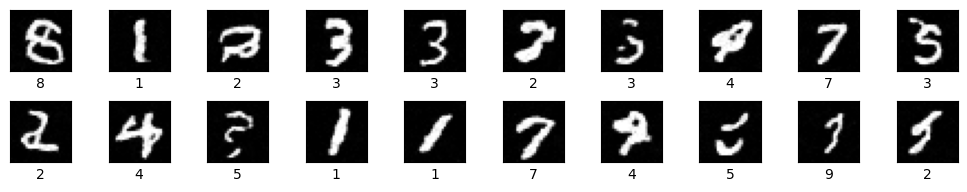

100%|██████████| 469/469 [00:24<00:00, 18.80it/s]


Epoch 5 | Loss: 0.019050058305088772


100%|██████████| 1000/1000 [00:05<00:00, 198.02it/s]


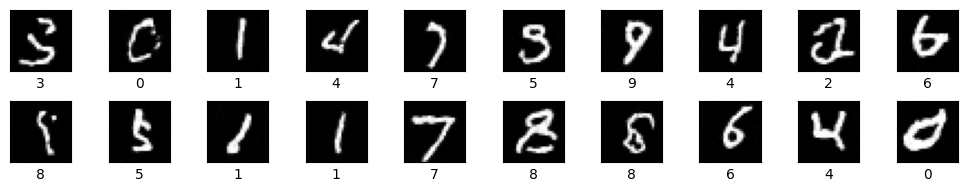

100%|██████████| 469/469 [00:25<00:00, 18.76it/s]


Epoch 6 | Loss: 0.01821182514709641


100%|██████████| 1000/1000 [00:05<00:00, 198.62it/s]


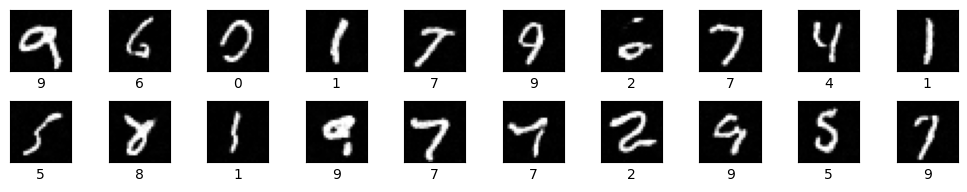

100%|██████████| 469/469 [00:24<00:00, 18.82it/s]


Epoch 7 | Loss: 0.017896915408673445


100%|██████████| 1000/1000 [00:05<00:00, 198.09it/s]


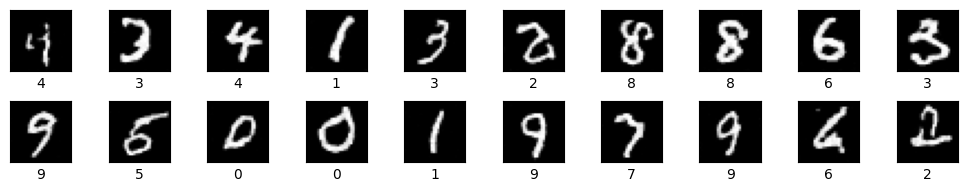

100%|██████████| 469/469 [00:25<00:00, 18.73it/s]


Epoch 8 | Loss: 0.017517964963290864


100%|██████████| 1000/1000 [00:05<00:00, 197.63it/s]


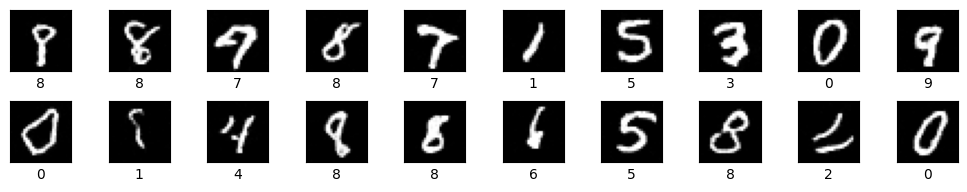

100%|██████████| 469/469 [00:25<00:00, 18.76it/s]


Epoch 9 | Loss: 0.0171033933337754


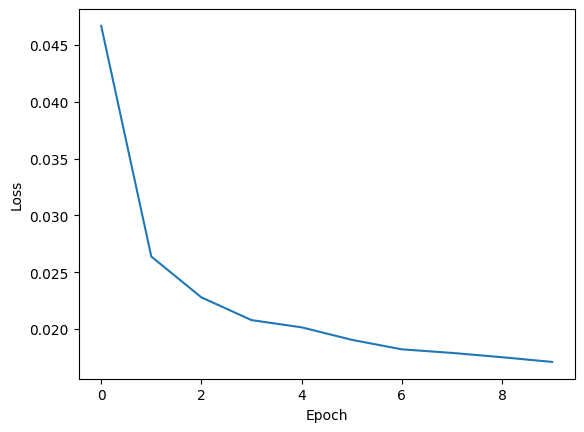

100%|██████████| 1000/1000 [00:05<00:00, 198.79it/s]


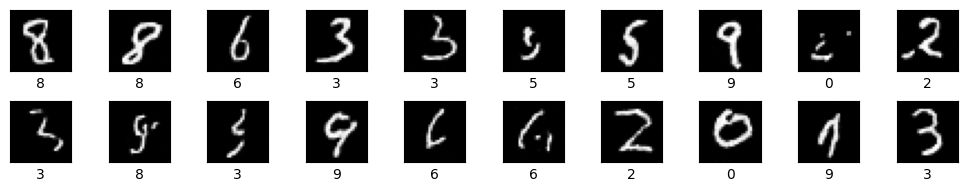

In [8]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

num_timesteps = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
epochs = 10
batch_size = 128

preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    images, labels = diffuser.sample(model)
    show_images(images, labels)
    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images, labels = diffuser.sample(model)
show_images(images, labels)

## スコア関数
$\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t\right)$のことをスコアと呼ぶ。ここで、$p\left(\boldsymbol{x}_t\right)$はデータ$\boldsymbol{x}_t$の真の確率密度関数を表し、$p_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t\right)$は真の確率密度関数に対してパラメータを使って近似している確率密度関数を表す。このスコアと教師データ$\boldsymbol{\epsilon}$について以下が成り立つ。
$$
\boldsymbol{\epsilon} \approx - \sqrt{1 - \bar{\alpha}}\nabla_{\boldsymbol{x}_t}\log p \left(\boldsymbol{x}_t\right)
$$

これより、$\boldsymbol{\epsilon}$はスコア$\nabla_{\boldsymbol{x}_t}\log p \left(\boldsymbol{x}_t\right)$によって表すことができるため、$-\frac{1}{\sqrt{1 - \bar{\alpha}}}\boldsymbol{\epsilon}$を教師データとするニューラルネットワークを考えることもできる。このNNは$s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t\right)$として、スコアの近似値である$- \frac{1}{\sqrt{1-\bar{\alpha}_t}}$を推定する。このようなスコアを推定するNNによっても拡散モデルを実現できる

上記のスコアについて導出する。
まず、拡散過程の$q\left(\boldsymbol{x}_t \mid \boldsymbol{x}_0\right)$について、
$$
\begin{align}
\boldsymbol{\epsilon} &\sim \mathcal{N}\left(\boldsymbol{0}, \boldsymbol{I}\right) \\
\boldsymbol{x}_t &= \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}
\end{align}
$$
とかける。ここで、Tweedieの公式より$\boldsymbol{x} \sim \mathcal{N}\left(\boldsymbol{x};\boldsymbol{\mu},\boldsymbol{\Sigma}\right)$によってサンプル$\boldsymbol{x}$が得られたときに以下が成り立つ
$$
\mathbb{E}\left[ \boldsymbol{\mu} \mid \boldsymbol{x} \right] = \boldsymbol{x}_t + \boldsymbol{\Sigma}\nabla_{\boldsymbol{x}}\log p\left(\boldsymbol{x}\right)
$$

このTweedieの公式を適用すると、$\boldsymbol{x}_t \sim \mathcal{N}\left(\boldsymbol{x}_t ; \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 , \left(1-\bar{\alpha}\right)\boldsymbol{I}\right)$によりサンプル$\boldsymbol{x}_t$が得られているため
$$
\begin{align}
\mathbb{E} \left[ \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 \mid \boldsymbol{x}_t \right] &= \boldsymbol{x}_t + \left(1 - \bar{\alpha}_t\right)\boldsymbol{I}\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t\right) \\
&= \boldsymbol{x}_t + \left(1 - \bar{\alpha}_t\right)\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t\right)
\end{align}
$$

これより、
$$
\begin{align}
& \mathbb{E} \left[ \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 \mid \boldsymbol{x}_t \right] = \boldsymbol{x}_t + \left(1 - \bar{\alpha}_t\right)\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t\right) \\
\Leftrightarrow & \mathbb{E} \left[ \boldsymbol{x}_t - \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon} \mid \boldsymbol{x}_t \right] = \boldsymbol{x}_t + \left(1 - \bar{\alpha}_t\right)\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t\right) \\
\Leftrightarrow & \mathbb{E}\left[\boldsymbol{x}_t \mid \boldsymbol{x}_t\right] - \mathbb{E}\left[\sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon} \mid \boldsymbol{x}_t\right] = \boldsymbol{x}_t + \left(1 - \bar{\alpha}_t\right)\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t\right) \\
\Leftrightarrow & \boldsymbol{x}_t  - \sqrt{1-\bar{\alpha}_t} \mathbb{E}\left[\boldsymbol{\epsilon} \mid \boldsymbol{x}_t\right] = \boldsymbol{x}_t + \left(1 - \bar{\alpha}_t\right)\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t\right) \\
\therefore & \mathbb{E}\left[\boldsymbol{\epsilon}\mid\boldsymbol{x}_t\right] = - \sqrt{1-\bar{\alpha}}\nabla_{\boldsymbol{x}_t}\log p \left(\boldsymbol{x}_t\right)
\end{align}
$$
$\mathbb{E}\left[\boldsymbol{\epsilon}\mid\boldsymbol{x}_t\right]$はモンテカルロ法で近似することができる。$\boldsymbol{x}_t$を1つのサンプリングデータで近似することにすると、
$$
\boldsymbol{\epsilon} \approx - \sqrt{1-\bar{\alpha}}\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t\right)
$$

## 分類器ガイダンス(Classifier Guidance)
分類器とは画像に対してそのクラスを推測するニューラルネットワーク$p_{\boldsymbol{\theta}}\left(y \mid \boldsymbol{x}_t\right)$を指す。

分類ガイダンスを導出する。

まず、条件付き確率の$p\left(\boldsymbol{x}_t \mid y \right)$についてベイズの定理より
$$
p\left(\boldsymbol{x}_t \mid y \right) = \frac{p\left(\boldsymbol{x}_t\right)p\left(y \mid \boldsymbol{x}_t\right)}{p\left(y\right)}
$$

この条件付き確率の勾配を求めると
$$
\begin{align}
\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t \mid y\right) &= \nabla_{\boldsymbol{x}_t}\log\left(\frac{p\left(\boldsymbol{x}_t\right)p\left(y \mid \boldsymbol{x}_t\right)}{p\left(y\right)}\right)\\
&= \nabla_{\boldsymbol{x}_t}\log p \left(\boldsymbol{x}_t\right) + \nabla_{\boldsymbol{x}_t} \log p\left(y \mid \boldsymbol{x}_t\right) - \underbrace{\nabla_{\boldsymbol{x}_t}\log p\left(y\right)}_{0}\\
&= \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right) + \nabla_{\boldsymbol{x}_t} \log p \left(y \mid \boldsymbol{x}_t\right)
\end{align}
$$

以上より
$$
\underbrace{\nabla_{\boldsymbol{x}_t}\log p \left(\boldsymbol{x}_t \mid y\right)}_{\text{条件付きスコア}} = \underbrace{\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right)}_{\text{①スコア}} + \underbrace{\nabla_{\boldsymbol{x}_t} \log p \left(y \mid \boldsymbol{x}_t\right)}_{\text{②分類器の対数尤度の勾配}}
$$
①の項はスコアを予測するニューラルネットワーク$s_{\boldsymbol{\theta}}\left(\boldsymbol{x},t\right)$によって計算可能。②の項は分類器であるNNを使って計算可能。

よって、スコアと分類器という2つのNNを使って条件付きのスコアを表すことができる。よってスコアを予測するタイプの拡散モデルに条件を加えることができた。

$\nabla_{\boldsymbol{x}_t}\log p\left(y \mid \boldsymbol{x}_t\right)$は現在の$\boldsymbol{x}_t$においてクラス$y$の対数尤度を高くする方向を示すため、$\boldsymbol{x}_t$を
$\nabla_{\boldsymbol{x}_t}\log p\left(y \mid \boldsymbol{x}_t\right)$の方向へ更新すれば更新後の画像がクラス$y$に分類される確率が高くなる

分類器ガイダンスではこの分類器の貢献度を調整するためのハイパーパラメータ$\gamma$を使って
$$
\nabla_{\boldsymbol{x}_t}\log p \left(\boldsymbol{x}_t \mid y\right) = \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right) + \gamma \nabla_{\boldsymbol{x}_t} \log p \left(y \mid \boldsymbol{x}_t\right)
$$
とする。そのため$\gamma$が大きければ大きいほど条件$y$を強く取り入れることになる。

これをスコアを推定するNNと分類器のNNで書き直すと
$$
\nabla_{\boldsymbol{x}_t}\log p \left(\boldsymbol{x}_t \mid y\right) \approx s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t\right) + \gamma \nabla_{\boldsymbol{x}_t} \log p_{\boldsymbol{\phi}} \left(y \mid \boldsymbol{x}_t\right)
$$

## 分類器なしガイダンス(Classifier-Free Guidance)
分類器ガイダンスの問題点として、学習済み分類器を用意する必要があるという点がある。そこで分類器を必要としない分類器なしガイダンス(Classifier-Free Guidance)がある。これは、分類器ガイダンスで導出した式の$p\left(y \mid \boldsymbol{x}_t\right)$をNNで表現するのではなくベイズの定理で展開することで導出できる。
$$
\begin{align}
& \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t \mid y\right) \\
=& \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right) + \gamma \nabla_{\boldsymbol{x}_t} \log p \left(y \mid \boldsymbol{x}_t\right)\\
=& \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right) + \gamma \nabla_{\boldsymbol{x}_t} \log \frac{p\left(\boldsymbol{x}_t \mid y\right)p\left(y\right)}{p\left(\boldsymbol{x}_t\right)}\\
=& \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right) + \gamma \left(\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t \mid y\right) + \underbrace{\nabla_{\boldsymbol{x}_t} \log p \left(y\right)}_{0} - \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right)\right) \\
=& \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right) + \gamma \left(\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t \mid y\right) - \nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right)\right)
\end{align}
$$
これは、$\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right)$の点から$\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t \mid y\right)$の方向へ$\gamma$倍の距離だけ進むことを意味する。

$\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t\right)$は条件なしのスコアであり、$\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t \mid y\right)$は条件付きのスコアであるため、これらは以下の2つのニューラルネットワークで実現できる
- 条件なしのスコア推定器 : $s_{\boldsymbol{\theta_1}}\left(\boldsymbol{x}_t, t\right)$
- 条件付きのスコア推定器 : $s_{\boldsymbol{\theta_2}}\left(\boldsymbol{x}_t, t, y\right)$

条件なしというのを以下のように考えることで1つのNNで実現できる
- 条件なしのスコア推定器 : $s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, \emptyset\right)$
- 条件付きのスコア推定器 : $s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, y\right)$
このように条件なしに該当するクラスを$\emptyset$で表現して、クラスが$\emptyset$の時は0ベクトルに変換して何も情報を持たないようにする。

以上より分類器なしガイダンスは以下の式でかける
$$
\nabla_{\boldsymbol{x}_t} \log p \left(\boldsymbol{x}_t \mid y \right) \approx s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, \emptyset\right) + \gamma \left(s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, y\right) -  s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, \emptyset\right)\right)
$$


(ちなみに、Stable Diffusionなどで使われるNegative Promptはこの$\emptyset$にNegative Promptを入れることで実現している)

## 分類器なしガイダンスの実装
以前と同じように前処理と条件付きUNetを実装する。

In [1]:
import math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm


img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def show_images(images, labels=None, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            if labels is not None:
                ax.set_xlabel(labels[i].item())
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            i += 1
    plt.tight_layout()
    plt.show()

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device)
    return v

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

class UNetCond(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100, num_labels=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        if num_labels is not None:
            self.label_emb = nn.Embedding(num_labels, time_embed_dim)

    def forward(self, x, timesteps, labels=None):
        t = pos_encoding(timesteps, self.time_embed_dim)

        if labels is not None:
            t += self.label_emb(labels)

        x1 = self.down1(x, t)
        x = self.maxpool(x1)
        x2 = self.down2(x, t)
        x = self.maxpool(x2)

        x = self.bot1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x, t)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x, t)
        x = self.out(x)
        return x


これまで導出してきたのは以下のようなノイズをスコアで近似する式と条件付きスコアをスコア型のdiffusion modelで近似する式である
$$
\begin{align}
\boldsymbol{\epsilon} &\approx - \sqrt{1-\bar{\alpha}_t}\nabla_{\boldsymbol{x}_t}\log p \left(\boldsymbol{x}_t\right)\\
\nabla_{\boldsymbol{x}_t}\log p\left(\boldsymbol{x}_t \mid y\right) &\approx s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, \emptyset\right) + \gamma\left(s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, y\right) - s_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, \emptyset\right)\right)
\end{align}
$$
ここでは、スコアに$-\sqrt{1-\bar{\alpha}_t}$をかけるとノイズになることから以下を実装する
$$
\boldsymbol{\epsilon} \approx \epsilon_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, \emptyset\right) + \gamma\left(\epsilon_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, y\right) - \epsilon_{\boldsymbol{\theta}}\left(\boldsymbol{x}_t, t, \emptyset\right)\right)
$$

In [2]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]  # (N,)
        alpha_bar = alpha_bar.view(alpha_bar.size(0), 1, 1, 1)  # (N, 1, 1, 1)

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t, labels, gamma): # ハイパーパラメータgamma追加
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t, labels) # これが条件付き
            eps_uncond = model(x, t) # これが条件なし
            eps = eps_uncond + gamma * (eps - eps_uncond) # Classifier-Free Guidanceの計算式でノイズ計算
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha) # 予測ノイズから平均計算
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28), labels=None, gamma=3.0):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)
        if labels is None:
            labels = torch.randint(0, 10, (len(x),), device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t, labels, gamma)

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
        return images, labels


分類器なしガイダンスの学習では、条件付き拡散モデルを条件無しと条件ありの2つの場合でおこなう。ここでは、10%の確率で条件なしで学習するコードを実装する

100%|██████████| 1000/1000 [00:08<00:00, 118.46it/s]


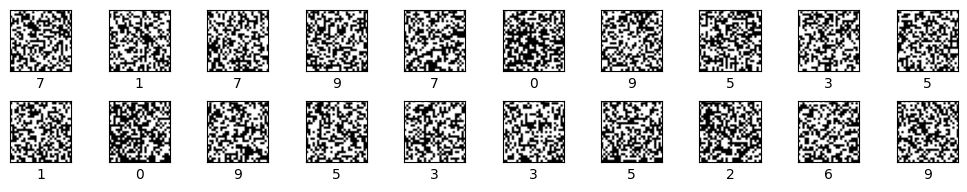

100%|██████████| 469/469 [00:26<00:00, 17.83it/s]


Epoch 0 | Loss: 0.05165685085790244


100%|██████████| 1000/1000 [00:08<00:00, 117.92it/s]


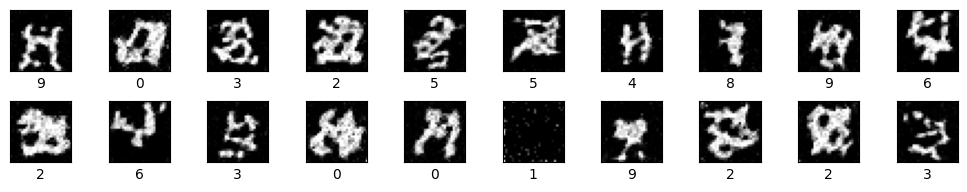

100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Epoch 1 | Loss: 0.027395480373965653


100%|██████████| 1000/1000 [00:08<00:00, 120.51it/s]


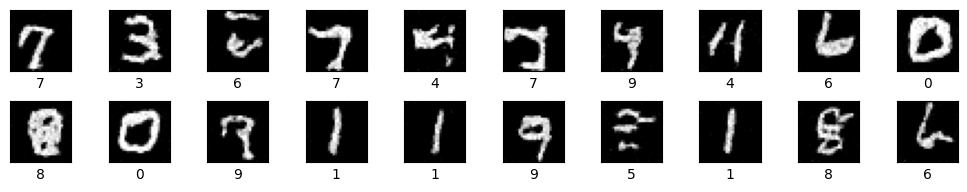

100%|██████████| 469/469 [00:26<00:00, 17.83it/s]


Epoch 2 | Loss: 0.023567937107991054


100%|██████████| 1000/1000 [00:08<00:00, 118.99it/s]


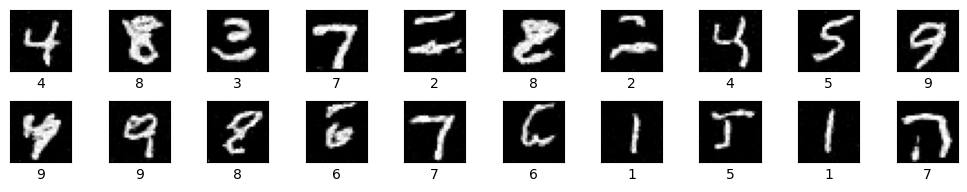

100%|██████████| 469/469 [00:26<00:00, 17.70it/s]


Epoch 3 | Loss: 0.021617254939303596


100%|██████████| 1000/1000 [00:08<00:00, 114.74it/s]


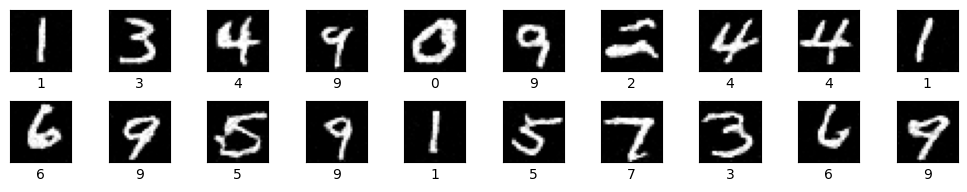

100%|██████████| 469/469 [00:26<00:00, 17.45it/s]


Epoch 4 | Loss: 0.020011811886530822


100%|██████████| 1000/1000 [00:08<00:00, 118.49it/s]


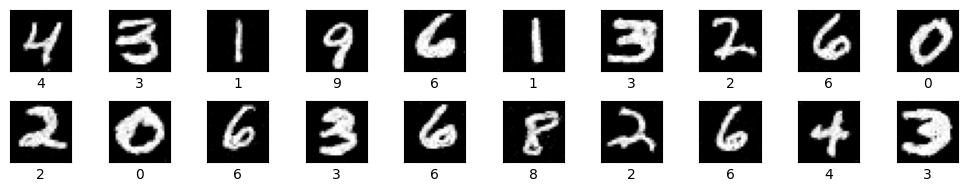

100%|██████████| 469/469 [00:26<00:00, 17.56it/s]


Epoch 5 | Loss: 0.019874222763279863


100%|██████████| 1000/1000 [00:08<00:00, 119.12it/s]


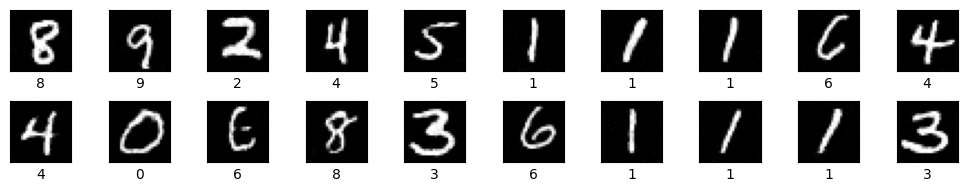

100%|██████████| 469/469 [00:26<00:00, 17.62it/s]


Epoch 6 | Loss: 0.018817632633851153


100%|██████████| 1000/1000 [00:08<00:00, 118.65it/s]


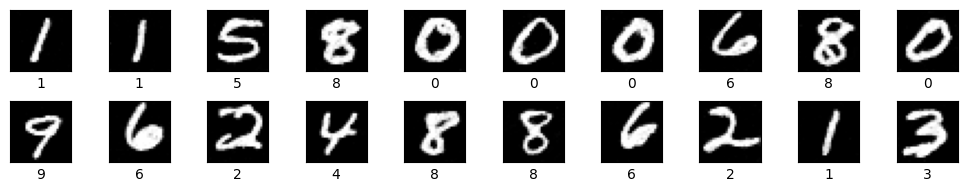

100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Epoch 7 | Loss: 0.01863217262078577


100%|██████████| 1000/1000 [00:08<00:00, 119.75it/s]


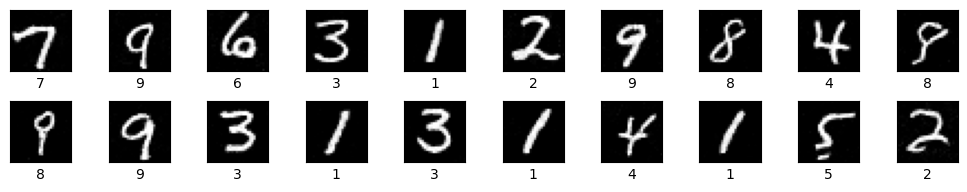

100%|██████████| 469/469 [00:26<00:00, 17.71it/s]


Epoch 8 | Loss: 0.018046165417347635


100%|██████████| 1000/1000 [00:08<00:00, 119.39it/s]


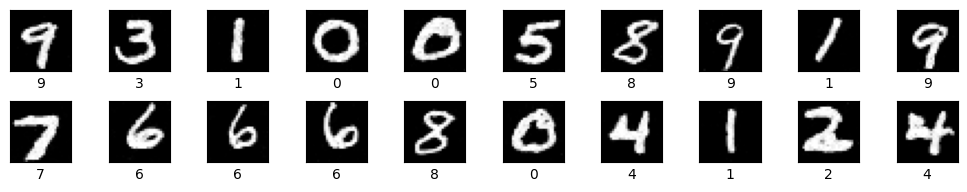

100%|██████████| 469/469 [00:26<00:00, 17.73it/s]


Epoch 9 | Loss: 0.017239254792091815


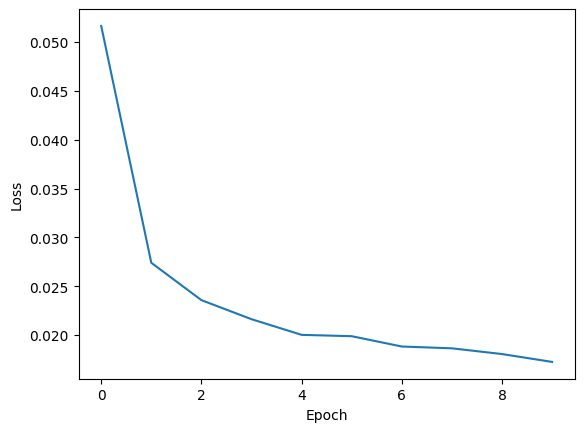

100%|██████████| 1000/1000 [00:08<00:00, 115.95it/s]


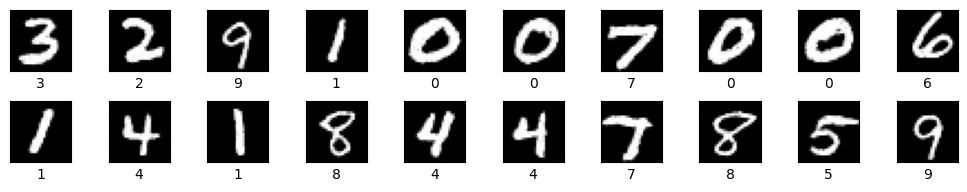

In [3]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNetCond(num_labels=10)
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch
    images, labels = diffuser.sample(model)
    show_images(images, labels)

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        labels = labels.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

        # 10%の確率で条件なしで学習する
        if np.random.random() < 0.1:
            labels = None

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t, labels)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images, labels = diffuser.sample(model)
show_images(images, labels)

## Stable Diffusion
paper-summary/diffusion/ldm参照
## Diffuser
hugging faceの拡散モデルライブラリ